In [4]:
import torch
from torch.autograd import Variable
dtype = torch.FloatTensor

In [5]:
import numpy as np
pi = np.pi

## Simultaneous search for policy and verifying Lyapunov function

$$\dot{x} = f(x,u)$$

$$ u = \pi_\theta(x)) $$

$$ V(x) = p.s.d. \text{by construction, but parameterized by parameters } \psi $$

$$ \dot{V} = \frac{dV}{dx} \dot{x}$$
$$ = \big[ \frac{dV}{dx}\big]^T \big[f(x,\pi_{\theta}(x) \big] $$

### Loss function

$X$ = {$x_1, x_2, ..., x_N$} many samples

$$ L(\theta) = \sum_{i} l(x_i, \theta) $$

\begin{equation}
  \mathcal{l}(x_i,\theta) =
  \begin{cases}
    \dot{V}(x_i, \theta) & \text{if $\dot{V}(x_i, \theta) > 0$} \\
    0 & \text{otherwise}
  \end{cases}
\end{equation}



In [7]:
l = 1.0   # length in pixels
g = 1.0    # gravity in m/s**2
m = 1.0    # mass in kg
b = 1.0    # damping

x_i = Variable(torch.FloatTensor([1.0, 1.1]).type(dtype), requires_grad=True)
print x_i

P = Variable(torch.FloatTensor([1, 1]).type(dtype), requires_grad=True)
print P
### Step 1: compute V(x)
def compute_V(x):
    '''V(x) = x_1^2 + x_2^2'''
    x_desired = Variable(torch.FloatTensor([0, 0]).type(dtype), requires_grad=False)
    x_squared = (x-x_desired).pow(2)
    return torch.dot(P, x_squared)

def compute_V_energy_based(x):
    '''V(x) = (E - E_d)^2'''
    energy = 0.5*m*l**2*x[1]**2 + m*g*l*torch.cos(x[0])
    energy_desired = m*g*l
    difference_squared = (energy-energy_desired).pow(2)
    return difference_squared

print x_i.shape
print "V is", compute_V_energy_based(x_i)
x_i_2 = Variable(torch.FloatTensor([1.1, 2.2]).type(dtype), requires_grad=True)
print "V is", compute_V_energy_based(x_i_2)

many_x_i = Variable(torch.FloatTensor([[1.0, 1.1, 2.0],[1.1, 2.2, 3.0]]).type(dtype), requires_grad=True)

def compute_V_vectorized(x):
    x_desired = Variable(torch.FloatTensor([0, 0]).type(dtype), requires_grad=False)
    x_desired_vectorized = torch.t(x_desired.repeat(x.shape[1], 1))
    x_squared = (x-x_desired_vectorized).pow(2)
    P_transpose = torch.t(P.unsqueeze(1))
    return P_transpose.mm(x_squared)

def compute_V_energy_based_vectorized(x):
    energy_vectorized = 0.5*m*l**2*x[1,:].pow(2) + m*g*l*torch.cos(x[0,:])
    energy_desired = m*g*l
    difference_squared = (energy_vectorized-energy_desired).pow(2)
    return difference_squared
    
print many_x_i
print compute_V_energy_based_vectorized(many_x_i)

Variable containing:
 1.0000
 1.1000
[torch.FloatTensor of size 2]

Variable containing:
 1
 1
[torch.FloatTensor of size 2]

torch.Size([2])
V is Variable containing:
1.00000e-02 *
  2.1113
[torch.FloatTensor of size 1]

V is Variable containing:
 3.5104
[torch.FloatTensor of size 1]

Variable containing:
 1.0000  1.1000  2.0000
 1.1000  2.2000  3.0000
[torch.FloatTensor of size 2x3]

Variable containing:
 0.0211
 3.5104
 9.5102
[torch.FloatTensor of size 3]



In [8]:
### Step 2: compute dV/dx

### Step 3: initialize policy parameters
K = Variable(torch.FloatTensor([1, 2]).type(dtype), requires_grad=True)
print K

### Step 4: define dynamics function
def dynamics(x):
    xdot = Variable(torch.zeros(2).type(dtype))
    xdot[0] = x[1]
    xdot[1] = -torch.dot(K,x)
    return xdot

def pendulum_policy(x):
    x_desired = Variable(torch.FloatTensor([0, 0]).type(dtype), requires_grad=False)
    return -torch.dot(K,x-x_desired)

def pendulum_energy_policy(x):
    energy = 0.5*m*l**2*x[1]**2 + m*g*l*torch.cos(x[0])
    energy_desired = m*g*l
    return -K[0]*x[1]*(energy - energy_desired)

def pendulum_dynamics(x):
    xdot = Variable(torch.zeros(2).type(dtype))
    xdot[0] = x[1]
    u = pendulum_energy_policy(x)
    xdot[1] = (m * g * l * torch.sin(x[0:1])) + u
    return xdot
    
xdot = pendulum_dynamics(x_i)
print xdot
print pendulum_dynamics(x_i_2)
print "energy policy is", pendulum_energy_policy(x_i)
print "energy policy is", pendulum_energy_policy(x_i_2)

many_x_i = Variable(torch.FloatTensor([[1.0, 1.1, 2.0],[1.1, 2.2, 3.0]]).type(dtype), requires_grad=True)

def dynamics_vectorized(x):
    xdot = Variable(torch.zeros(2,x.shape[1]).type(dtype))
    xdot[0,:] = x[1,:]
    K_transpose = torch.t(K.unsqueeze(1))
    xdot[1,:] = -K_transpose.mm(x)
    return xdot

def pendulum_policy_vectorized(x):
    x_desired = Variable(torch.FloatTensor([0, 0]).type(dtype), requires_grad=False)
    x_desired_vectorized = torch.t(x_desired.repeat(x.shape[1], 1))
    K_transpose = torch.t(K.unsqueeze(1))
    return -K_transpose.mm(x - x_desired_vectorized)

def pendulum_energy_policy_vectorized(x):
    energy_vectorized = 0.5*m*l**2*x[1,:]**2 + m*g*l*torch.cos(x[0,:])
    energy_desired = m*g*l
    return -K[0]*x[1,:]*(energy_vectorized - energy_desired)

def pendulum_dynamics_vectorized(x):
    xdot = Variable(torch.zeros(2,x.shape[1]).type(dtype))
    xdot[0,:] = x[1,:]
    u = pendulum_energy_policy_vectorized(x)
    xdot[1,:] = (m * g * l * torch.sin(x[0:1])) + u
    return xdot
      
print many_x_i
print pendulum_dynamics_vectorized(many_x_i)
print "energy policy is", pendulum_energy_policy_vectorized(many_x_i)

Variable containing:
 1
 2
[torch.FloatTensor of size 2]

Variable containing:
 1.1000
 0.6816
[torch.FloatTensor of size 2]

Variable containing:
 2.2000
-3.2307
[torch.FloatTensor of size 2]

energy policy is Variable containing:
-0.1598
[torch.FloatTensor of size 1]

energy policy is Variable containing:
-4.1219
[torch.FloatTensor of size 1]

Variable containing:
 1.0000  1.1000  2.0000
 1.1000  2.2000  3.0000
[torch.FloatTensor of size 2x3]

Variable containing:
 1.1000  2.2000  3.0000
 0.6816 -3.2307 -8.3423
[torch.FloatTensor of size 2x3]

energy policy is Variable containing:
-0.1598
-4.1219
-9.2516
[torch.FloatTensor of size 3]



In [9]:
def compute_Vdot(x):
    V = compute_V_energy_based(x)
#     print x.shape
#     print V.shape
#     print V
    V.backward(torch.ones(1).type(dtype),retain_graph=True)
#     print "x.grad is", x.grad
    jacobian_x = Variable(x.grad.data)
#     print "jacobian_x is", jacobian_x
    f = pendulum_dynamics(x)
    Vdot = torch.dot(jacobian_x,f)
    return Vdot

print "x_i is", x_i
if x_i.grad is not None:
    print x_i.grad.zero_()
Vdot = compute_Vdot(x_i)
print "Vdot is", Vdot
Vdot.backward()

def compute_Vdot_vectorized(x):
    V = compute_V_energy_based_vectorized(x)
#     print V
#     print x.shape
#     print "x.grad is", x.grad
#    V.backward(torch.ones(1,1).type(dtype),retain_graph=True)
#     print x
    V.backward(torch.ones(1,x.shape[1]).type(dtype),retain_graph=True)
    jacobian_x = Variable(x.grad.data)
#     print "jacobian_x is", jacobian_x
    f = pendulum_dynamics_vectorized(x)
    Vdot = (jacobian_x*f).sum(dim=0)
    return Vdot

print "many_x_i is", many_x_i

Vdot_vec = compute_Vdot_vectorized(many_x_i)
print "Vdot_vec is", Vdot_vec
#Vdot.backward(torch.ones(many_x_i.shape[1]).type(dtype))
cost = Vdot_vec.clamp(min=0).sum()
print cost
cost.backward()
many_x_i.grad.data.zero_()



x_i is Variable containing:
 1.0000
 1.1000
[torch.FloatTensor of size 2]

Vdot is Variable containing:
1.00000e-02 *
 -5.1093
[torch.FloatTensor of size 1]

many_x_i is Variable containing:
 1.0000  1.1000  2.0000
 1.1000  2.2000  3.0000
[torch.FloatTensor of size 2x3]

Vdot_vec is Variable containing:
  -0.0511
 -33.9803
-171.1827
[torch.FloatTensor of size 3]

Variable containing:
 0
[torch.FloatTensor of size 1]




 0  0  0
 0  0  0
[torch.FloatTensor of size 2x3]

## First let's verify, no synthesis
 
K = [1, 2] and P = [1, 1] should be stable

In [10]:
K = Variable(torch.FloatTensor([1, 2]).type(dtype), requires_grad=True)
P = Variable(torch.FloatTensor([1, 1]).type(dtype), requires_grad=True)
for i in range(10000):
    x_i = Variable(torch.randn(2).type(dtype), requires_grad=True)
    Vdot = compute_Vdot(x_i)
    if Vdot.data[0] > 0:
        print "false, counterexample found: ", x_i
        print i
        print compute_V(x_i)
        print Vdot.data[0]
        break

## Now let's search for K, from an initialization not stable

In [10]:
P = Variable(torch.rand(2).type(dtype), requires_grad=True)
K = Variable(torch.randn(2).type(dtype), requires_grad=True)

print "Initial P", P
print "Initial K", K


for i in range(10000):
    x_i = Variable(torch.randn(2).type(dtype), requires_grad=True)
    Vdot = compute_Vdot(x_i)
    if Vdot.data[0] > 0:
        print "false, counterexample found: ", x_i
        break

Initial P Variable containing:
 0.3302
 0.5347
[torch.FloatTensor of size 2]

Initial K Variable containing:
 1.1510
-1.0992
[torch.FloatTensor of size 2]

false, counterexample found:  Variable containing:
 0.4571
 0.1288
[torch.FloatTensor of size 2]



In [11]:
# Reset 
P = Variable(torch.rand(2).type(dtype), requires_grad=True)
K = Variable(torch.randn(2).type(dtype), requires_grad=True)

<IPython.core.display.Javascript object>


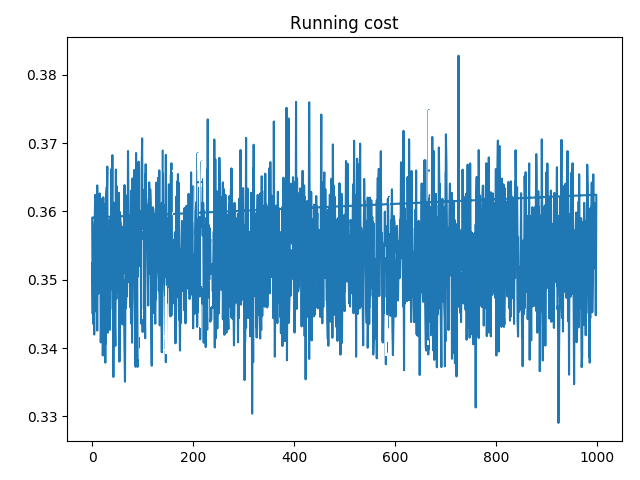

In [12]:
## optimization plotting tool

cost_current_iteration = 0
cost_history = []
cost_iteration_number_history = []

f, (cost_axis) = plt.subplots(1, 1)

cost_axis.plot(cost_iteration_number_history, cost_history)
cost_axis.set_title('Running cost')

plt.tight_layout()

In [14]:
## optimize

num_iterations = 1000
num_samples_per_iteration = 10000
step_rate = 1e-2
slack_var = .00

# K has already been initialized above, and initial policy visualized

import time
print "first P is", P
print "first K is", K

for cost_iteration in range(num_iterations):
    
    start = time.time()
    
    cost = 0
    
    samples = 0.2*(torch.rand(2,num_samples_per_iteration).type(dtype)*2 - torch.ones(2,num_samples_per_iteration))
    many_x_i = Variable(samples, requires_grad=True)
    Vdot = compute_Vdot_vectorized(many_x_i)
    cost = Vdot.clamp(min=-slack_var).sum()
        
    ## Automatically differentiate
    cost.backward()

    # Update K via gradient descent
    K.data -= step_rate * K.grad.data
    #P.data -= step_rate * P.grad.data
    
    # Project P into feasible
    #P.data = torch.abs(P.data)
    # Make P numerically stable by normalizing
    #P.data = P.data/(P.data.pow(2).sum())
      
    # Manually zero the gradients after running the backward pass
    K.grad.data.zero_()
    #P.grad.data.zero_()
    
    print time.time() - start, "is time for one step of grad descent"
    print 
    print cost.data[0]
    
    # handle plotting
    cost_history.append(cost.data[0])
    cost_iteration_number_history.append(cost_iteration)
    
    if cost_iteration % 10 == 0:
        cost_axis.lines[0].set_xdata(cost_iteration_number_history)
        cost_axis.lines[0].set_ydata(cost_history)
        cost_axis.relim()
        cost_axis.autoscale_view()
        cost_axis.figure.canvas.draw()
        
    if cost.data[0] == 0:
        break
        
    print "P is", P
    print "K is", K
    
    if cost_iteration == num_iterations - 1:
        print "didn't converge"

first P is Variable containing:
 0.9135
 0.8881
[torch.FloatTensor of size 2]

first K is Variable containing:
 0.1434
-0.8217
[torch.FloatTensor of size 2]

0.00351691246033 is time for one step of grad descent

0.359088033438
P is Variable containing:
 0.9135
 0.8881
[torch.FloatTensor of size 2]

K is Variable containing:
 0.1434
-0.8217
[torch.FloatTensor of size 2]

0.00270414352417 is time for one step of grad descent

0.345006644726
P is Variable containing:
 0.9135
 0.8881
[torch.FloatTensor of size 2]

K is Variable containing:
 0.1434
-0.8217
[torch.FloatTensor of size 2]

0.00303912162781 is time for one step of grad descent

0.355755209923
P is Variable containing:
 0.9135
 0.8881
[torch.FloatTensor of size 2]

K is Variable containing:
 0.1435
-0.8217
[torch.FloatTensor of size 2]

0.00336098670959 is time for one step of grad descent

0.356931567192
P is Variable containing:
 0.9135
 0.8881
[torch.FloatTensor of size 2]

K is Variable containing:
 0.1435
-0.8217
[torch.Fl

0.00530695915222 is time for one step of grad descent

0.34848678112
P is Variable containing:
 0.9135
 0.8881
[torch.FloatTensor of size 2]

K is Variable containing:
 0.1449
-0.8217
[torch.FloatTensor of size 2]

0.00321793556213 is time for one step of grad descent

0.353453457355
P is Variable containing:
 0.9135
 0.8881
[torch.FloatTensor of size 2]

K is Variable containing:
 0.1450
-0.8217
[torch.FloatTensor of size 2]

0.0037829875946 is time for one step of grad descent

0.357226192951
P is Variable containing:
 0.9135
 0.8881
[torch.FloatTensor of size 2]

K is Variable containing:
 0.1450
-0.8217
[torch.FloatTensor of size 2]

0.00355386734009 is time for one step of grad descent

0.355566889048
P is Variable containing:
 0.9135
 0.8881
[torch.FloatTensor of size 2]

K is Variable containing:
 0.1450
-0.8217
[torch.FloatTensor of size 2]

0.00350689888 is time for one step of grad descent

0.350539982319
P is Variable containing:
 0.9135
 0.8881
[torch.FloatTensor of size 2]

0.00329494476318 is time for one step of grad descent

0.337236016989
P is Variable containing:
 0.9135
 0.8881
[torch.FloatTensor of size 2]

K is Variable containing:
 0.1461
-0.8217
[torch.FloatTensor of size 2]

0.00459504127502 is time for one step of grad descent

0.350696355104
P is Variable containing:
 0.9135
 0.8881
[torch.FloatTensor of size 2]

K is Variable containing:
 0.1462
-0.8217
[torch.FloatTensor of size 2]

0.00422692298889 is time for one step of grad descent

0.340007424355
P is Variable containing:
 0.9135
 0.8881
[torch.FloatTensor of size 2]

K is Variable containing:
 0.1462
-0.8217
[torch.FloatTensor of size 2]

0.00422310829163 is time for one step of grad descent

0.351665884256
P is Variable containing:
 0.9135
 0.8881
[torch.FloatTensor of size 2]

K is Variable containing:
 0.1462
-0.8217
[torch.FloatTensor of size 2]

0.00405311584473 is time for one step of grad descent

0.357614636421
P is Variable containing:
 0.9135
 0.8881
[torch.FloatTensor of si

0.0030620098114 is time for one step of grad descent

0.348909646273
P is Variable containing:
 0.9135
 0.8881
[torch.FloatTensor of size 2]

K is Variable containing:
 0.1478
-0.8217
[torch.FloatTensor of size 2]

0.00182604789734 is time for one step of grad descent

0.337921023369
P is Variable containing:
 0.9135
 0.8881
[torch.FloatTensor of size 2]

K is Variable containing:
 0.1478
-0.8217
[torch.FloatTensor of size 2]

0.00189113616943 is time for one step of grad descent

0.349045783281
P is Variable containing:
 0.9135
 0.8881
[torch.FloatTensor of size 2]

K is Variable containing:
 0.1479
-0.8217
[torch.FloatTensor of size 2]

0.00187397003174 is time for one step of grad descent

0.358991533518
P is Variable containing:
 0.9135
 0.8881
[torch.FloatTensor of size 2]

K is Variable containing:
 0.1479
-0.8217
[torch.FloatTensor of size 2]

0.00180602073669 is time for one step of grad descent

0.351771116257
P is Variable containing:
 0.9135
 0.8881
[torch.FloatTensor of siz

P is Variable containing:
 0.9135
 0.8881
[torch.FloatTensor of size 2]

K is Variable containing:
 0.1495
-0.8217
[torch.FloatTensor of size 2]

0.00222897529602 is time for one step of grad descent

0.348442792892
P is Variable containing:
 0.9135
 0.8881
[torch.FloatTensor of size 2]

K is Variable containing:
 0.1495
-0.8217
[torch.FloatTensor of size 2]

0.00198602676392 is time for one step of grad descent

0.351098239422
P is Variable containing:
 0.9135
 0.8881
[torch.FloatTensor of size 2]

K is Variable containing:
 0.1495
-0.8217
[torch.FloatTensor of size 2]

0.00199198722839 is time for one step of grad descent

0.348657220602
P is Variable containing:
 0.9135
 0.8881
[torch.FloatTensor of size 2]

K is Variable containing:
 0.1496
-0.8217
[torch.FloatTensor of size 2]

0.00207901000977 is time for one step of grad descent

0.355260372162
P is Variable containing:
 0.9135
 0.8881
[torch.FloatTensor of size 2]

K is Variable containing:
 0.1496
-0.8217
[torch.FloatTensor of

0.00516486167908 is time for one step of grad descent

0.361732244492
P is Variable containing:
 0.9135
 0.8881
[torch.FloatTensor of size 2]

K is Variable containing:
 0.1513
-0.8217
[torch.FloatTensor of size 2]

0.00309205055237 is time for one step of grad descent

0.34193071723
P is Variable containing:
 0.9135
 0.8881
[torch.FloatTensor of size 2]

K is Variable containing:
 0.1513
-0.8217
[torch.FloatTensor of size 2]

0.00387191772461 is time for one step of grad descent

0.351783484221
P is Variable containing:
 0.9135
 0.8881
[torch.FloatTensor of size 2]

K is Variable containing:
 0.1514
-0.8217
[torch.FloatTensor of size 2]

0.0037260055542 is time for one step of grad descent

0.36241209507
P is Variable containing:
 0.9135
 0.8881
[torch.FloatTensor of size 2]

K is Variable containing:
 0.1514
-0.8217
[torch.FloatTensor of size 2]

0.00347113609314 is time for one step of grad descent

0.35558822751
P is Variable containing:
 0.9135
 0.8881
[torch.FloatTensor of size 2

0.00365209579468 is time for one step of grad descent

0.348484784365
P is Variable containing:
 0.9135
 0.8881
[torch.FloatTensor of size 2]

K is Variable containing:
 0.1531
-0.8217
[torch.FloatTensor of size 2]

0.00241208076477 is time for one step of grad descent

0.347634226084
P is Variable containing:
 0.9135
 0.8881
[torch.FloatTensor of size 2]

K is Variable containing:
 0.1531
-0.8217
[torch.FloatTensor of size 2]

0.00234389305115 is time for one step of grad descent

0.355017900467
P is Variable containing:
 0.9135
 0.8881
[torch.FloatTensor of size 2]

K is Variable containing:
 0.1532
-0.8217
[torch.FloatTensor of size 2]

0.00232410430908 is time for one step of grad descent

0.354572623968
P is Variable containing:
 0.9135
 0.8881
[torch.FloatTensor of size 2]

K is Variable containing:
 0.1532
-0.8217
[torch.FloatTensor of size 2]

0.00230503082275 is time for one step of grad descent

0.343028366566
P is Variable containing:
 0.9135
 0.8881
[torch.FloatTensor of si

0.00372791290283 is time for one step of grad descent

0.344547271729
P is Variable containing:
 0.9135
 0.8881
[torch.FloatTensor of size 2]

K is Variable containing:
 0.1548
-0.8217
[torch.FloatTensor of size 2]

0.00292301177979 is time for one step of grad descent

0.355115443468
P is Variable containing:
 0.9135
 0.8881
[torch.FloatTensor of size 2]

K is Variable containing:
 0.1549
-0.8217
[torch.FloatTensor of size 2]

0.0029239654541 is time for one step of grad descent

0.35410374403
P is Variable containing:
 0.9135
 0.8881
[torch.FloatTensor of size 2]

K is Variable containing:
 0.1549
-0.8217
[torch.FloatTensor of size 2]

0.00393295288086 is time for one step of grad descent

0.353780448437
P is Variable containing:
 0.9135
 0.8881
[torch.FloatTensor of size 2]

K is Variable containing:
 0.1549
-0.8217
[torch.FloatTensor of size 2]

0.00362110137939 is time for one step of grad descent

0.341014504433
P is Variable containing:
 0.9135
 0.8881
[torch.FloatTensor of size

0.00428009033203 is time for one step of grad descent

0.358351737261
P is Variable containing:
 0.9135
 0.8881
[torch.FloatTensor of size 2]

K is Variable containing:
 0.1560
-0.8217
[torch.FloatTensor of size 2]

0.00306916236877 is time for one step of grad descent

0.365931242704
P is Variable containing:
 0.9135
 0.8881
[torch.FloatTensor of size 2]

K is Variable containing:
 0.1560
-0.8217
[torch.FloatTensor of size 2]

0.00291013717651 is time for one step of grad descent

0.351546466351
P is Variable containing:
 0.9135
 0.8881
[torch.FloatTensor of size 2]

K is Variable containing:
 0.1560
-0.8217
[torch.FloatTensor of size 2]

0.00295400619507 is time for one step of grad descent

0.343305498362
P is Variable containing:
 0.9135
 0.8881
[torch.FloatTensor of size 2]

K is Variable containing:
 0.1561
-0.8217
[torch.FloatTensor of size 2]

0.00277400016785 is time for one step of grad descent

0.363801747561
P is Variable containing:
 0.9135
 0.8881
[torch.FloatTensor of si

P is Variable containing:
 0.9135
 0.8881
[torch.FloatTensor of size 2]

K is Variable containing:
 0.1576
-0.8217
[torch.FloatTensor of size 2]

0.00330400466919 is time for one step of grad descent

0.362449139357
P is Variable containing:
 0.9135
 0.8881
[torch.FloatTensor of size 2]

K is Variable containing:
 0.1576
-0.8217
[torch.FloatTensor of size 2]

0.00311994552612 is time for one step of grad descent

0.345210283995
P is Variable containing:
 0.9135
 0.8881
[torch.FloatTensor of size 2]

K is Variable containing:
 0.1577
-0.8217
[torch.FloatTensor of size 2]

0.00313186645508 is time for one step of grad descent

0.343828558922
P is Variable containing:
 0.9135
 0.8881
[torch.FloatTensor of size 2]

K is Variable containing:
 0.1577
-0.8217
[torch.FloatTensor of size 2]

0.00403308868408 is time for one step of grad descent

0.364771991968
P is Variable containing:
 0.9135
 0.8881
[torch.FloatTensor of size 2]

K is Variable containing:
 0.1577
-0.8217
[torch.FloatTensor of

P is Variable containing:
 0.9135
 0.8881
[torch.FloatTensor of size 2]

K is Variable containing:
 0.1594
-0.8217
[torch.FloatTensor of size 2]

0.0020489692688 is time for one step of grad descent

0.369912683964
P is Variable containing:
 0.9135
 0.8881
[torch.FloatTensor of size 2]

K is Variable containing:
 0.1595
-0.8217
[torch.FloatTensor of size 2]

0.00182104110718 is time for one step of grad descent

0.351728409529
P is Variable containing:
 0.9135
 0.8881
[torch.FloatTensor of size 2]

K is Variable containing:
 0.1595
-0.8217
[torch.FloatTensor of size 2]

0.00182509422302 is time for one step of grad descent

0.357596129179
P is Variable containing:
 0.9135
 0.8881
[torch.FloatTensor of size 2]

K is Variable containing:
 0.1595
-0.8217
[torch.FloatTensor of size 2]

0.00240302085876 is time for one step of grad descent

0.356663018465
P is Variable containing:
 0.9135
 0.8881
[torch.FloatTensor of size 2]

K is Variable containing:
 0.1596
-0.8217
[torch.FloatTensor of 

P is Variable containing:
 0.9135
 0.8881
[torch.FloatTensor of size 2]

K is Variable containing:
 0.1609
-0.8217
[torch.FloatTensor of size 2]

0.00320196151733 is time for one step of grad descent

0.349784314632
P is Variable containing:
 0.9135
 0.8881
[torch.FloatTensor of size 2]

K is Variable containing:
 0.1610
-0.8217
[torch.FloatTensor of size 2]

0.00327610969543 is time for one step of grad descent

0.337618410587
P is Variable containing:
 0.9135
 0.8881
[torch.FloatTensor of size 2]

K is Variable containing:
 0.1610
-0.8217
[torch.FloatTensor of size 2]

0.00323104858398 is time for one step of grad descent

0.351665139198
P is Variable containing:
 0.9135
 0.8881
[torch.FloatTensor of size 2]

K is Variable containing:
 0.1610
-0.8217
[torch.FloatTensor of size 2]

0.00322699546814 is time for one step of grad descent

0.33940500021
P is Variable containing:
 0.9135
 0.8881
[torch.FloatTensor of size 2]

K is Variable containing:
 0.1611
-0.8217
[torch.FloatTensor of 

P is Variable containing:
 0.9135
 0.8881
[torch.FloatTensor of size 2]

K is Variable containing:
 0.1625
-0.8217
[torch.FloatTensor of size 2]

0.00343012809753 is time for one step of grad descent

0.361011922359
P is Variable containing:
 0.9135
 0.8881
[torch.FloatTensor of size 2]

K is Variable containing:
 0.1625
-0.8217
[torch.FloatTensor of size 2]

0.00355792045593 is time for one step of grad descent

0.350672364235
P is Variable containing:
 0.9135
 0.8881
[torch.FloatTensor of size 2]

K is Variable containing:
 0.1625
-0.8217
[torch.FloatTensor of size 2]

0.0035228729248 is time for one step of grad descent

0.36590436101
P is Variable containing:
 0.9135
 0.8881
[torch.FloatTensor of size 2]

K is Variable containing:
 0.1625
-0.8217
[torch.FloatTensor of size 2]

0.00350308418274 is time for one step of grad descent

0.356953144073
P is Variable containing:
 0.9135
 0.8881
[torch.FloatTensor of size 2]

K is Variable containing:
 0.1626
-0.8217
[torch.FloatTensor of s


0.339642494917
P is Variable containing:
 0.9135
 0.8881
[torch.FloatTensor of size 2]

K is Variable containing:
 0.1638
-0.8217
[torch.FloatTensor of size 2]

0.00301003456116 is time for one step of grad descent

0.351820319891
P is Variable containing:
 0.9135
 0.8881
[torch.FloatTensor of size 2]

K is Variable containing:
 0.1639
-0.8217
[torch.FloatTensor of size 2]

0.00290083885193 is time for one step of grad descent

0.338758766651
P is Variable containing:
 0.9135
 0.8881
[torch.FloatTensor of size 2]

K is Variable containing:
 0.1639
-0.8217
[torch.FloatTensor of size 2]

0.0029821395874 is time for one step of grad descent

0.344273149967
P is Variable containing:
 0.9135
 0.8881
[torch.FloatTensor of size 2]

K is Variable containing:
 0.1639
-0.8217
[torch.FloatTensor of size 2]

0.00270795822144 is time for one step of grad descent

0.348839432001
P is Variable containing:
 0.9135
 0.8881
[torch.FloatTensor of size 2]

K is Variable containing:
 0.1640
-0.8217
[torch

P is Variable containing:
 0.9135
 0.8881
[torch.FloatTensor of size 2]

K is Variable containing:
 0.1655
-0.8217
[torch.FloatTensor of size 2]

0.00281691551208 is time for one step of grad descent

0.354102641344
P is Variable containing:
 0.9135
 0.8881
[torch.FloatTensor of size 2]

K is Variable containing:
 0.1655
-0.8217
[torch.FloatTensor of size 2]

0.00278091430664 is time for one step of grad descent

0.357344031334
P is Variable containing:
 0.9135
 0.8881
[torch.FloatTensor of size 2]

K is Variable containing:
 0.1655
-0.8217
[torch.FloatTensor of size 2]

0.00298094749451 is time for one step of grad descent

0.351413756609
P is Variable containing:
 0.9135
 0.8881
[torch.FloatTensor of size 2]

K is Variable containing:
 0.1656
-0.8217
[torch.FloatTensor of size 2]

0.00381183624268 is time for one step of grad descent

0.366113394499
P is Variable containing:
 0.9135
 0.8881
[torch.FloatTensor of size 2]

K is Variable containing:
 0.1656
-0.8217
[torch.FloatTensor of

0.00429582595825 is time for one step of grad descent

0.354742854834
P is Variable containing:
 0.9135
 0.8881
[torch.FloatTensor of size 2]

K is Variable containing:
 0.1671
-0.8217
[torch.FloatTensor of size 2]

0.00258994102478 is time for one step of grad descent

0.350924283266
P is Variable containing:
 0.9135
 0.8881
[torch.FloatTensor of size 2]

K is Variable containing:
 0.1672
-0.8217
[torch.FloatTensor of size 2]

0.00291299819946 is time for one step of grad descent

0.353437334299
P is Variable containing:
 0.9135
 0.8881
[torch.FloatTensor of size 2]

K is Variable containing:
 0.1672
-0.8217
[torch.FloatTensor of size 2]

0.00291609764099 is time for one step of grad descent

0.353277385235
P is Variable containing:
 0.9135
 0.8881
[torch.FloatTensor of size 2]

K is Variable containing:
 0.1672
-0.8217
[torch.FloatTensor of size 2]

0.00281405448914 is time for one step of grad descent

0.356339782476
P is Variable containing:
 0.9135
 0.8881
[torch.FloatTensor of si

P is Variable containing:
 0.9135
 0.8881
[torch.FloatTensor of size 2]

K is Variable containing:
 0.1685
-0.8217
[torch.FloatTensor of size 2]

0.00335693359375 is time for one step of grad descent

0.34722840786
P is Variable containing:
 0.9135
 0.8881
[torch.FloatTensor of size 2]

K is Variable containing:
 0.1685
-0.8217
[torch.FloatTensor of size 2]

0.00318503379822 is time for one step of grad descent

0.355087906122
P is Variable containing:
 0.9135
 0.8881
[torch.FloatTensor of size 2]

K is Variable containing:
 0.1686
-0.8217
[torch.FloatTensor of size 2]

0.00325798988342 is time for one step of grad descent

0.356603175402
P is Variable containing:
 0.9135
 0.8881
[torch.FloatTensor of size 2]

K is Variable containing:
 0.1686
-0.8217
[torch.FloatTensor of size 2]

0.00326991081238 is time for one step of grad descent

0.356557756662
P is Variable containing:
 0.9135
 0.8881
[torch.FloatTensor of size 2]

K is Variable containing:
 0.1686
-0.8217
[torch.FloatTensor of 

P is Variable containing:
 0.9135
 0.8881
[torch.FloatTensor of size 2]

K is Variable containing:
 0.1700
-0.8217
[torch.FloatTensor of size 2]

0.00252199172974 is time for one step of grad descent

0.364282518625
P is Variable containing:
 0.9135
 0.8881
[torch.FloatTensor of size 2]

K is Variable containing:
 0.1700
-0.8217
[torch.FloatTensor of size 2]

0.0022029876709 is time for one step of grad descent

0.342247188091
P is Variable containing:
 0.9135
 0.8881
[torch.FloatTensor of size 2]

K is Variable containing:
 0.1701
-0.8217
[torch.FloatTensor of size 2]

0.0024139881134 is time for one step of grad descent

0.354732215405
P is Variable containing:
 0.9135
 0.8881
[torch.FloatTensor of size 2]

K is Variable containing:
 0.1701
-0.8217
[torch.FloatTensor of size 2]

0.00222182273865 is time for one step of grad descent

0.362950205803
P is Variable containing:
 0.9135
 0.8881
[torch.FloatTensor of size 2]

K is Variable containing:
 0.1701
-0.8217
[torch.FloatTensor of s

P is Variable containing:
 0.9135
 0.8881
[torch.FloatTensor of size 2]

K is Variable containing:
 0.1715
-0.8217
[torch.FloatTensor of size 2]

0.00329899787903 is time for one step of grad descent

0.344402611256
P is Variable containing:
 0.9135
 0.8881
[torch.FloatTensor of size 2]

K is Variable containing:
 0.1715
-0.8217
[torch.FloatTensor of size 2]

0.00332617759705 is time for one step of grad descent

0.362437069416
P is Variable containing:
 0.9135
 0.8881
[torch.FloatTensor of size 2]

K is Variable containing:
 0.1716
-0.8217
[torch.FloatTensor of size 2]

0.0030210018158 is time for one step of grad descent

0.35339358449
P is Variable containing:
 0.9135
 0.8881
[torch.FloatTensor of size 2]

K is Variable containing:
 0.1716
-0.8217
[torch.FloatTensor of size 2]

0.00356316566467 is time for one step of grad descent

0.353478074074
P is Variable containing:
 0.9135
 0.8881
[torch.FloatTensor of size 2]

K is Variable containing:
 0.1716
-0.8217
[torch.FloatTensor of s

P is Variable containing:
 0.9135
 0.8881
[torch.FloatTensor of size 2]

K is Variable containing:
 0.1730
-0.8217
[torch.FloatTensor of size 2]

0.00458216667175 is time for one step of grad descent

0.351566642523
P is Variable containing:
 0.9135
 0.8881
[torch.FloatTensor of size 2]

K is Variable containing:
 0.1731
-0.8217
[torch.FloatTensor of size 2]

0.00443291664124 is time for one step of grad descent

0.34900867939
P is Variable containing:
 0.9135
 0.8881
[torch.FloatTensor of size 2]

K is Variable containing:
 0.1731
-0.8217
[torch.FloatTensor of size 2]

0.00325608253479 is time for one step of grad descent

0.349357098341
P is Variable containing:
 0.9135
 0.8881
[torch.FloatTensor of size 2]

K is Variable containing:
 0.1731
-0.8217
[torch.FloatTensor of size 2]

0.00311398506165 is time for one step of grad descent

0.34505674243
P is Variable containing:
 0.9135
 0.8881
[torch.FloatTensor of size 2]

K is Variable containing:
 0.1732
-0.8217
[torch.FloatTensor of s

In [15]:
print K
print P

Variable containing:
 1.3718
 1.6788
[torch.FloatTensor of size 2]

Variable containing:
 0.3685
 0.2295
[torch.FloatTensor of size 2]



## Analytical pendulum controller... need to think about

$$x = 
       \begin{bmatrix} x_1 \\ x_2
        \end{bmatrix} $$

$$\dot{x} = f(x,u) =
       \begin{bmatrix} x_2 \\ u
        \end{bmatrix} $$
        
Policy

$$ u = \pi_K(x) = -K^Tx = - k_1x_1 - k_2x_2$$
        
Lyapunov

$$V(x) = P^Tx = p_1x_1^2 + p_2x_2^2 = \text{p.s.d. by construction}$$

$$\dot{V}(x) = \bigg[ \frac{\partial V}{\partial x}\bigg]^T \big[f(x,\pi_K(x) \big] $$

$$ = \begin{bmatrix} 2p_1x_1 \\ 2p_2x_2
        \end{bmatrix}^T \begin{bmatrix} x_2 \\ -k_1x_1 - k_2x_2
        \end{bmatrix} $$
        
$$ =  2p_1x_1x_2 + 2p_2x_2( - k_1x_1 - k_2x_2) $$

$$ =  2p_1x_1x_2 - 2p_2k_1x_1x_2 - 2p_2k_2x_2^2 $$

We need both terms to be negative semidefinite:

$$ =  2x_1x_2(p_1 - p_2k_1 ) - 2p_2k_2x_2^2 $$

Therefore conditions are:

a) $p_1 = p_2k_1$

b) $k_2 > 0$ ($p_2$ already must be $> 0$) 

In [16]:
for i in range(10000):
    x_i = Variable(torch.randn(2).type(dtype), requires_grad=True)
    Vdot = compute_Vdot(x_i)
    if Vdot.data[0] > 1e-2:
        print "false, counterexample found: ", x_i
        print i
        print Vdot.data[0]
        break

false, counterexample found:  Variable containing:
 1.4091
-1.0566
[torch.FloatTensor of size 2]

4
0.532507181168


In [15]:
# Note: first time I ended up with these values:

# print K
# print P
# Variable containing:
#   0.2410
#  16.2734
# [torch.FloatTensor of size 2]

# Variable containing:
#  0.3484
#  0.8831
# [torch.FloatTensor of size 2]

#Which gave only:

# # condition (a):  p_1 - p_2*k_1
# print P[0] - P[1]*K[0]

# # condition (b): k_2 > 0
# print K[1]

# Variable containing:
#  0.1356
# [torch.FloatTensor of size 1]

# Variable containing:
#  16.2734
# [torch.FloatTensor of size 1]

# But this was Vdot negative semidefinite over all samples, since k_2 was so large it could outweigh the first term